In [1]:
!pip install transformers -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.4 MB/s eta 0:00:00


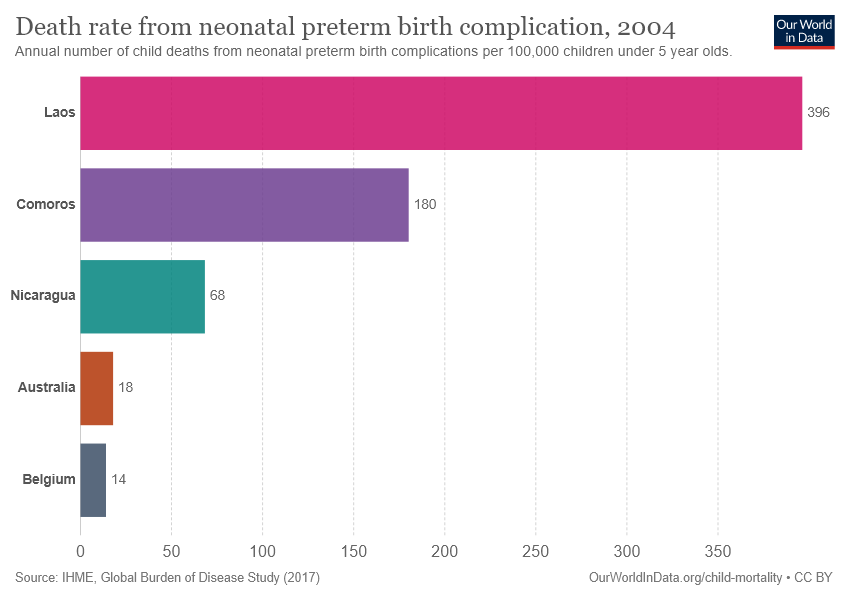

In [2]:
from PIL import Image
import requests

import torch
from transformers import AutoProcessor, Pix2StructForConditionalGeneration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/20294671002019.png"
image = Image.open(requests.get(url, stream=True).raw)
image

## ChartQA


In [3]:
model_name_or_path = "google/matcha-chartqa"
model = Pix2StructForConditionalGeneration.from_pretrained(model_name_or_path).to(device)
processor = AutoProcessor.from_pretrained(model_name_or_path)

config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

## Define a function for inference.

In [4]:
def chartqa(question: str, image: Image) -> str:
    """Function to execute ChartQA using MatCha"""
    inputs = processor(images=image, text=question, return_tensors="pt").to(device)
    predictions = model.generate(**inputs, max_new_tokens=512)
    answer = processor.decode(predictions[0], skip_special_tokens=True)
    return answer

# Q1. What does the horizontal axis indicate?
chartqa("What does the horizontal axis indicate?", image)



Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

'Child death rate from neonatal preterm birth complications'

In [5]:
# Q3. Which country has the nth highest mortality rate?
for n in ["first", "second", "third", "fourth", "fifth"]:
    answer = chartqa(f"Which country has the {n} highest mortality rate?", image)
    print(f"[{n}]\t{answer}")

[first]	Laos
[second]	Comoros
[third]	Nicaragua
[fourth]	Mexico
[fifth]	Australia


### Chart2Text

In [6]:
model_name_or_path = "google/matcha-chart2text-statista"
model = Pix2StructForConditionalGeneration.from_pretrained(model_name_or_path).to(device)
processor = AutoProcessor.from_pretrained(model_name_or_path, is_vqa=False)

#Function for Inference
def chart2text(image:Image) -> str:
    inputs = processor(images=image, return_tensors="pt").to(device)
    flattened_patches = inputs.flattened_patches
    attention_mask = inputs.attention_mask
    predictions = model.generate(**inputs, max_new_tokens=512)
    summary = processor.decode(predictions[0], skip_special_tokens=True)
    return summary

chart2text(image)

config.json:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

'The pre-100,000th of births in Laos per 100,000 children were the deadliest countries for neonatal preterm birth in 2004. The rate of neonatal preterm birth compared to 5-year-olds in Indonesia was 396 that year.<0x0A>'

### DocVQA implementation based on Pix2Struct

In [2]:
!pip install pdf2image
!sudo apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (132 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121747 

In [3]:
from pdf2image import convert_from_path, convert_from_bytes
import torch
from functools import partial
from PIL import Image
from transformers import Pix2StructForConditionalGeneration as psg
from transformers import Pix2StructProcessor as psp

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = psg.from_pretrained("google/pix2struct-docvqa-large").to(DEVICE)
processor = psp.from_pretrained("google/pix2struct-docvqa-large")

config.json:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.34G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

#### Some processing functions:



In [5]:
def generate(model, processor, img, questions):
  inputs = processor(images=[img for _ in range(len(questions))],
           text=questions, return_tensors="pt").to(DEVICE)
  predictions = model.generate(**inputs, max_new_tokens=256)
  return zip(questions, processor.batch_decode(predictions, skip_special_tokens=True))

def convert_pdf_to_image(filename, page_no):
    return convert_from_path(filename)[page_no-1]

In [6]:
questions = ["what is the seller name?",
             "what is the date of issue?",
             "What is Delivery address?",
             "What is Tax Id of client?"]
FILENAME = "/content/invoice_1.pdf"
PAGE_NO = 1

In [7]:
image = convert_pdf_to_image(FILENAME, PAGE_NO)
print("pdf to image conversion complete.")
generator = partial(generate, model, processor)
completions = generator(image, questions)
for completion in completions:
    print(f"{completion}")

pdf to image conversion complete.


Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

('what is the seller name?', 'chapman, kim and green')
('what is the date of issue?', '09/06/2012')
('What is Delivery address?', '2280 Angela plain')
('What is Tax Id of client?', '939-98-8477')


### Resources

- https://note.com/catshun_/n/n592fcf9abcc3
- https://zhuanlan.zhihu.com/p/669147630
- https://nowokay.hatenablog.com/entry/2023/04/24/200009
- https://github.com/khadkechetan/information_extraction/blob/main/Docvqa/pix2struct/Pix2Struct_docVQA.ipynb

